In [72]:
import pandas as pd
import polars as pl
import torch
from utils.plot_utils import set_theme, predict
from torchmetrics import R2Score, MeanSquaredError
import matplotlib.pyplot as plt
import seaborn as sns

set_theme()

In [73]:
from lightning_model import Netlightning

model = Netlightning.load_from_checkpoint(
    "../runs/regression_bloom/bloom2013_regression/bloom2013_regression-epoch=38-step=15327.ckpt",
    loss_function="mse",
)
model.eval()

Netlightning(
  (net): Net(
    (activation): GELU(approximate='none')
    (sequence): Sequential(
      (0): Linear(in_features=6078, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=1024, out_features=512, bias=True)
      (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): GELU(approximate='none')
      (6): Linear(in_features=512, out_features=256, bias=True)
      (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): GELU(approximate='none')
      (9): Linear(in_features=256, out_features=128, bias=True)
      (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): GELU(approximate='none')
      (12): Dropout(p=0.8992, inplace=False)
      (13): Linear(in_features=128, out_features=1, bias=True)
    )
  )
  (train_

In [74]:
train = "Bloom2013"
test = "Bloom2013"
filename="../data/regression_data/bloom2013_regression.feather"

In [75]:
test_data = pd.read_feather(filename)
test_data.drop(columns=["Strain"], inplace=True)
variation_columns = [col for col in test_data.columns if col.startswith("Y")]
test_data.head()

,YAL001C,YAL002W,YAL003W,YAL004W,YAL005C,YAL007C,YAL008W,YAL009W,YAL010C,YAL011W,...,latent_56,latent_57,latent_58,latent_59,latent_60,latent_61,latent_62,latent_63,Phenotype,Condition
0,0,0,0,0,0,0,0,0,0,0,...,-1.701524,-2.37987,3.69037,3.703681,-1.473729,2.430253,0.682124,-1.826363,-7.323520,CdCl2
1,0,1,1,0,1,0,0,0,1,1,...,-1.701524,-2.37987,3.69037,3.703681,-1.473729,2.430253,0.682124,-1.826363,-8.098236,CdCl2
2,0,1,1,0,1,0,0,0,1,1,...,-1.701524,-2.37987,3.69037,3.703681,-1.473729,2.430253,0.682124,-1.826363,7.605720,CdCl2
3,0,0,0,0,0,0,0,0,0,0,...,-1.701524,-2.37987,3.69037,3.703681,-1.473729,2.430253,0.682124,-1.826363,-6.147649,CdCl2
4,0,1,1,0,1,0,0,0,0,0,...,-1.701524,-2.37987,3.69037,3.703681,-1.473729,2.430253,0.682124,-1.826363,9.379060,CdCl2


In [76]:
test_data.Condition.unique().size

39

In [77]:
results_df = pd.DataFrame(columns=["Compound", "MSE", "R-squared"])

# fig, axes = plt.subplots(5, 8, figsize=(16,12), sharex=True, sharey=True, tight_layout=True)

pred_dict = dict()
mse = MeanSquaredError()
r2 = R2Score()

for i, key in enumerate(test_data.Condition.unique()):
    
    condition_test = test_data[test_data["Condition"] == key]
    X = torch.tensor(condition_test.drop(["Condition","Phenotype"], axis=1).values).float()
    y = torch.tensor(condition_test["Phenotype"].values).float().unsqueeze(1)
    
    y_pred = predict(model, X).to("cpu")

    mse_val = mse(y_pred, y).detach().item()
    r2_val = r2(y_pred, y).detach().item()
    
    print(f"{key}", end=": ")
    print(f"MSE:  {mse_val:.2f}", " | ", f"R2: , {r2_val:.2f}")
    
    pred_dict[key] = y_pred.reshape(-1).detach().numpy()
    
    results_df.loc[i] = [key, mse_val, r2_val]
    

CdCl2: MSE:  19.21  |  R2: , 0.39
caffeine: MSE:  0.75  |  R2: , 0.09
CaCl2: MSE:  0.53  |  R2: , 0.06
cisplatin: MSE:  0.98  |  R2: , 0.09
CoCl2: MSE:  7.80  |  R2: , 0.01
congo_red: MSE:  8.66  |  R2: , 0.78
copper: MSE:  2.12  |  R2: , 0.33
cycloheximide: MSE:  1.16  |  R2: , 0.59
diamide: MSE:  5.53  |  R2: , 0.75
berbamine: MSE:  13.42  |  R2: , 0.73
ethanol: MSE:  1.76  |  R2: , 0.52
formamide: MSE:  1.13  |  R2: , 0.29
galactose: MSE:  1.12  |  R2: , 0.25
H2O2: MSE:  3.63  |  R2: , 0.64
hydroquinone: MSE:  2.32  |  R2: , 0.49
hydroxyurea: MSE:  1.89  |  R2: , 0.57
indoleacetic_acid: MSE:  1.03  |  R2: , 0.49
lactate: MSE:  0.73  |  R2: , 0.58
lactose: MSE:  1.91  |  R2: , 0.39
LiCl: MSE:  3.21  |  R2: , 0.70
MgCl2: MSE:  0.92  |  R2: , 0.15
MgSO4: MSE:  2.05  |  R2: , 0.63
maltose: MSE:  7.32  |  R2: , 0.34
mannose: MSE:  1.15  |  R2: , 0.04
menadione: MSE:  0.61  |  R2: , 0.40
neomycin: MSE:  8.76  |  R2: , 0.76
paraquat: MSE:  1.74  |  R2: , 0.61
raffinose: MSE:  0.88  |  R2: 

In [78]:
results_df["Compound"] = results_df["Compound"].astype(str)
print(results_df[["MSE", "R-squared"]].apply(lambda x: str(x.mean()) + " ± " + str(x.std()), axis=0))

MSE             3.344449070783762 ± 4.064680126150538
R-squared    0.4473173511333955 ± 0.24624897904086257
dtype: object


Text(0.5, 0.98, 'Bloom2013 Model on Bloom2013')

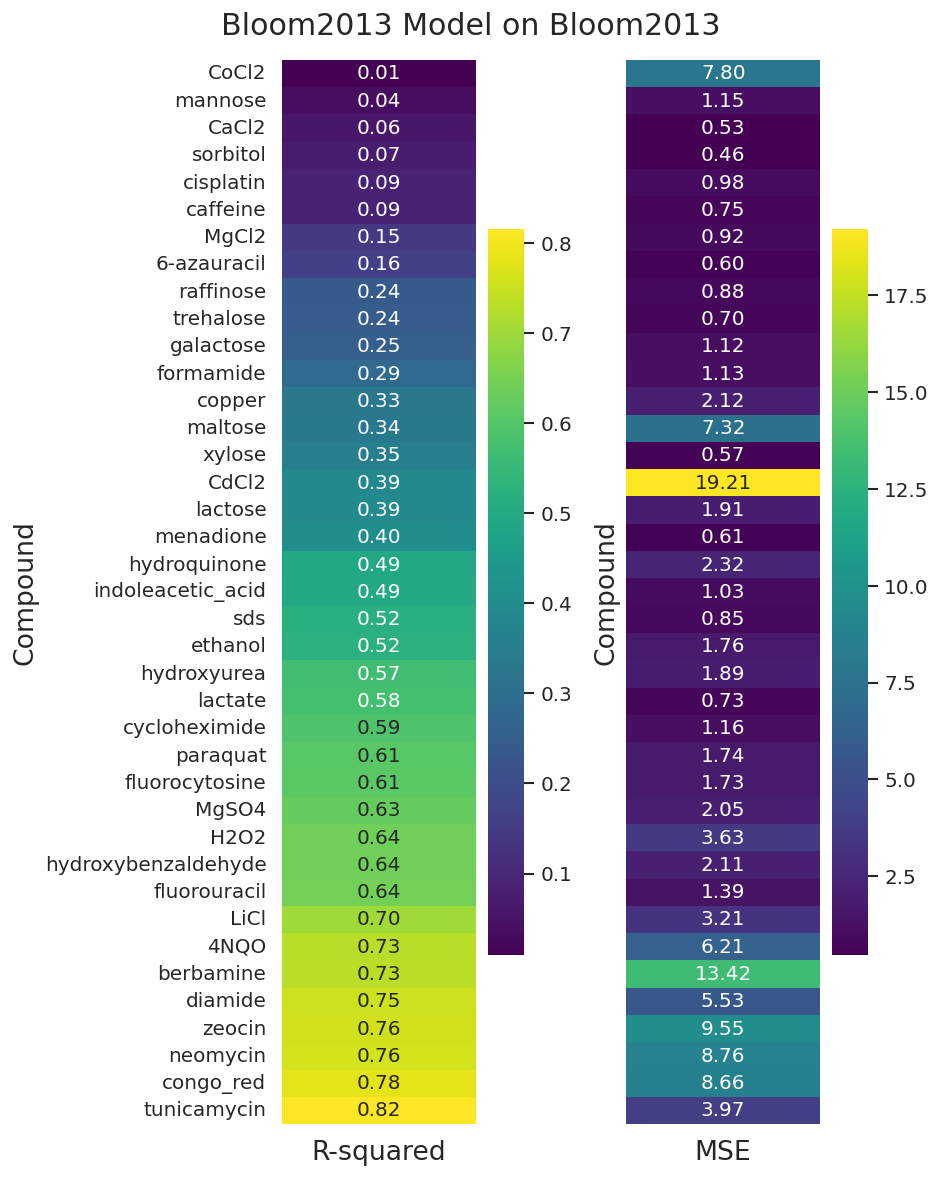

In [79]:
fig2, ax = plt.subplots(1,2,figsize=(8,10), sharey=True, tight_layout=True)

sns.heatmap(results_df.set_index('Compound').drop(['MSE'], axis=1).sort_values('R-squared'), cmap='viridis', annot=True, fmt='.2f', ax=ax[0])
sns.heatmap(results_df.set_index('Compound').sort_values('R-squared').drop(['R-squared'], axis=1), cmap='viridis', annot=True, fmt='.2f', ax=ax[1])
plt.suptitle(f"{train} Model on {test}", size=18)

<Axes: xlabel='Phenotype'>

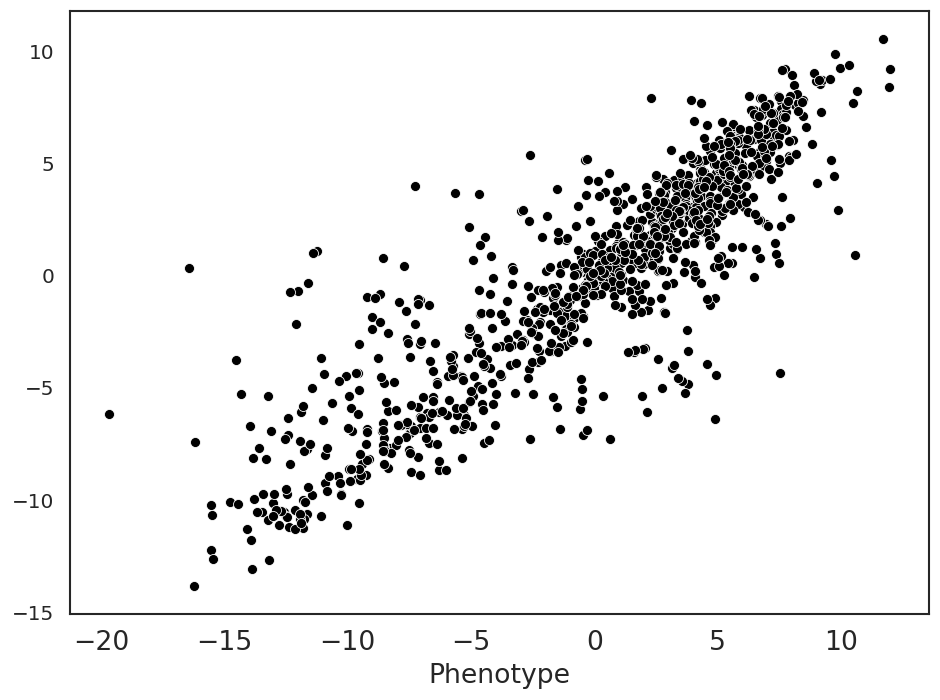

In [81]:
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)

sns.scatterplot(x=test_data[test_data["Condition"] == "neomycin"]["Phenotype"], y=pred_dict["neomycin"])